In [1]:
from typing import List, Tuple, Union
import argparse
import json
from math import sqrt, ceil
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import qiskit
from qiskit.circuit.library import PauliEvolutionGate, phase_estimation
from qiskit.synthesis import LieTrotter
from qiskit import transpile
import quimb.tensor as qtn
from quimb.tensor.tensor_1d import MatrixProductState
from tensor_network_common import pauli_sum_to_mpo, pauli_string_to_mpo, mps_to_vector
from convert import cirq_pauli_sum_to_qiskit_pauli_op
from kcommute import commutes
from qpe_trotter import (
    group_single_strings,
    # trotter_perturbation,
    bits_for_epsilon,
    get_gate_counts
)

In [2]:
def trotter_perturbation(hamiltonian_terms: List[cirq.PauliSum]) -> cirq.PauliSum:
    """Get the first order of the perturbation Hamiltonian in Eqn. 7 of Mehendale et al.
    Note that this does not include the factor of dt^2.
    
    Arguments:
    hamiltonian_terms - The terms {H_1, ..., H_n} used in the Trotter decomposition.
    
    Returns:
    H' - The perturbation to the Hamiltonian to second order in dt."""

    M = len(hamiltonian_terms)
    # print(f"M = {M}")
    h_prime = cirq.PauliSum()
    # TODO Can I parallelize this? Maybe only over the mu loop.
    for mu in range(2 * M - 1):
        if mu >= M:
            i = mu - M
            h_mu = hamiltonian_terms[M - 1 - i]
        else:
            h_mu = hamiltonian_terms[mu]
        for nu in range(mu+1, 2 * M):
            if nu >= M:
                i = nu - M
                h_nu = hamiltonian_terms[M - 1 - i]
            else:
                h_nu = hamiltonian_terms[nu]
            comm_nu_mu = h_nu * h_mu - h_mu * h_nu
            for nu_prime in range(nu, 2 * M):
                print(f"mu = {mu} nu = {nu} nu_prime = {nu_prime}")
                if nu_prime >= M:
                    i = nu_prime - M
                    h_nu_prime = hamiltonian_terms[M - 1 - i]
                else:
                    h_nu_prime = hamiltonian_terms[nu_prime]
                comm_three = h_nu_prime * comm_nu_mu - comm_nu_mu * h_nu_prime
                if nu_prime == nu:
                    delta = 1.
                else:
                    delta = 0.
                # print(mu, nu, nu_prime)
                # print(1 - delta / 2)
                # print(comm_three)
                h_prime += (1. - delta / 2.) * comm_three
    return -1. / 24. * h_prime

In [3]:
def num_summands(m: int) -> float:
    """Get the number of terms in the summation."""

    total = 0.
    for mu in range(1, 2 * m):
        nu_sum = -0.5 * (mu - 2 * m) * (2 * m + 1 + mu)
        total += float(2 * m + 1) * (2 * m - mu) - nu_sum
    return total


def sample_eps2(
    hamiltonian: cirq.PauliSum, qs: List[cirq.Qid], ground_state: Union[np.ndarray, MatrixProductState],
    samples: int, interval: int=10, max_mpo_bond: int=100
) -> Tuple[List[int], List[float], int]:
    """Estimate eps2 by sampling terms uniformly."""

    hamiltonian_terms = [ps for ps in hamiltonian]
    M = len(hamiltonian_terms)
    # num_sum = num_summands(M)
    # print(f"{num_sum} terms in summation.")
    sample_checkpoints = []
    sample_num_checkpoints = []
    num_zero = 0
    running_estimate = 0.
    v2 = cirq.PauliSum()
    for n in range(samples):
        mu = np.random.randint(0, 2 * M - 1)
        nu = np.random.randint(mu + 1, 2 * M)
        nu_prime = np.random.randint(nu, 2 * M)
        p_mu = 1. / len(range(0, 2 * M - 1))
        p_nu = 1. / len(range(mu + 1, 2 * M))
        p_nu_prime = 1. / len(range(nu, 2 * M))
        p = p_mu * p_nu * p_nu_prime
        if mu >= M:
            i = mu - M
            h_mu = hamiltonian_terms[M - 1 - i]
        else:
            h_mu = hamiltonian_terms[mu]
        if nu >= M:
            i = nu - M
            h_nu = hamiltonian_terms[M - 1 - i]
        else:
            h_nu = hamiltonian_terms[nu]
        if nu_prime >= M:
            i = nu_prime - M
            h_nu_prime = hamiltonian_terms[M - 1 - i]
        else:
            h_nu_prime = hamiltonian_terms[nu_prime]
        if nu_prime == nu:
            delta = 1.
        else:
            delta = 0.
        comm_nu_mu = h_nu * h_mu - h_mu * h_nu
        comm_three = h_nu_prime * comm_nu_mu - comm_nu_mu * h_nu_prime
        # print(mu, nu, nu_prime)
        # print(f"p = {p}")
        # print(1 - delta / 2)
        # print(comm_three)
        if len(comm_three) != 0:
            if isinstance(ground_state, MatrixProductState):
                comm_three_mpo = pauli_sum_to_mpo(comm_three, qs, max_mpo_bond)
                mat_elem = ground_state.H @ comm_three_mpo.apply(ground_state)
                running_estimate += (1 - delta / 2) * mat_elem.real / p
            else:
                qubit_map = {q: i for i, q in enumerate(qs)}
                mat_elem = comm_three.expectation_from_state_vector(ground_state, qubit_map)
                running_estimate += (1 - delta / 2) * mat_elem.real / p
            v2 += (-1 / 24.) * (1 - delta / 2) * comm_three / p
        else:
            num_zero += 1
        if n % interval == 0 or n == samples - 1:
            sample_checkpoints.append((-1 / 24.) * running_estimate / float(n + 1))
            sample_num_checkpoints.append(n+1)
    return sample_num_checkpoints, sample_checkpoints, v2 / float(samples)

## Simple model

In [4]:
nq = 1
psi = np.zeros(2 ** nq, dtype=complex)
psi[0] = 1 / sqrt(2)
psi[1] = -1 / sqrt(2)
print(psi)
psi_mps = MatrixProductState.from_dense(psi)

qs = cirq.LineQubit.range(nq)
ham = cirq.PauliSum()
for i in range(nq):
    ham += 1.0 * cirq.Z.on(qs[i]) + 1.0 * cirq.X.on(qs[i])

[ 0.70710678+0.j -0.70710678+0.j]


In [5]:
max_mpo_bond = 100
groups = [ps for ps in ham]
v2 = trotter_perturbation(groups)
print("v2 =", v2)
v2_mpo = pauli_sum_to_mpo(v2, qs, max_mpo_bond)
# Get energy from Mehendale Eqn. 8
eps2_exact = (psi_mps.H @ v2_mpo.apply(psi_mps)).real

qubit_map = {q: i for i, q in enumerate(qs)}
eps2_statevector = v2.expectation_from_state_vector(psi, qubit_map)

print(f"eps2 = {eps2_exact}")
print(f"eps2 from statevector = {eps2_statevector}")

mu = 0 nu = 1 nu_prime = 1
mu = 0 nu = 1 nu_prime = 2
mu = 0 nu = 1 nu_prime = 3
mu = 0 nu = 2 nu_prime = 2
mu = 0 nu = 2 nu_prime = 3
mu = 0 nu = 3 nu_prime = 3
mu = 1 nu = 2 nu_prime = 2
mu = 1 nu = 2 nu_prime = 3
mu = 1 nu = 3 nu_prime = 3
mu = 2 nu = 3 nu_prime = 3
v2 = -0.333*Z(q(0))+0.167*X(q(0))
eps2 = 9.149958124033984e-19
eps2 from statevector = (-0.16666666666666663+0j)


In [6]:
samples = 10_000
blocks = [qs]
num_samples, eps2_sampled, _ = sample_eps2(ham, qs, psi, samples)
print("Sampled eps2 =", eps2_sampled[-1])

Sampled eps2 = -0.16974999999999996


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


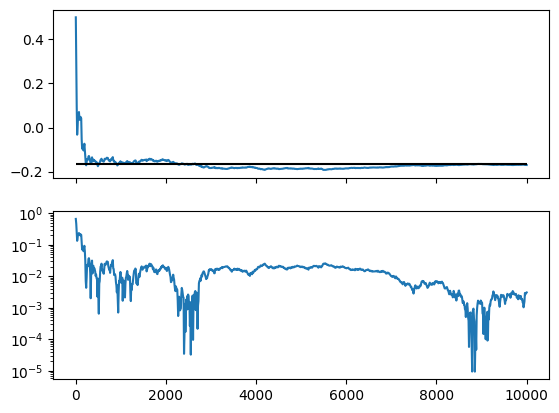

In [7]:
sample_error = np.abs(np.array(eps2_sampled) - eps2_statevector)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(num_samples, eps2_sampled)
ax[0].hlines(eps2_statevector, 0., max(num_samples), colors="k")
ax[1].plot(num_samples, sample_error)
ax[1].set_yscale("log")

## TFIM

In [8]:
def tfim_hamiltonian(l: int, j: float, g: float) -> cirq.PauliSum:
    """Hamiltonian for the transverse-field Ising model.
    H = -J (sum_ij Z_i Z_j + g sum_j X_j)
    Here we are using a 1D graph with non-periodic boundary conditions."""

    qs = cirq.LineQubit.range(l)
    h = cirq.PauliSum()
    for i in range(l):
        h += -j * g * cirq.X.on(qs[i])
        if i != l - 1:
            h += -j * cirq.Z.on(qs[i]) * cirq.Z.on(qs[i+1])
    return h

In [9]:
l = 3
qs = cirq.LineQubit.range(l)
j = 1.0
g = 2.0
hamiltonian = tfim_hamiltonian(l, j, g)
hamiltonian_terms = [ps for ps in hamiltonian]

In [10]:
psi = np.random.rand(2 ** l).astype(complex)
psi = psi / la.norm(psi)
v2 = trotter_perturbation(hamiltonian_terms)

print("v2 =")
for ps in v2:
    print(ps)

qubit_map = {q: i for i, q in enumerate(qs)}
eps2_exact = v2.expectation_from_state_vector(psi, qubit_map).real
print(f"eps2 = {eps2_exact:4.5e}")

mu = 0 nu = 1 nu_prime = 1
mu = 0 nu = 1 nu_prime = 2
mu = 0 nu = 1 nu_prime = 3
mu = 0 nu = 1 nu_prime = 4
mu = 0 nu = 1 nu_prime = 5
mu = 0 nu = 1 nu_prime = 6
mu = 0 nu = 1 nu_prime = 7
mu = 0 nu = 1 nu_prime = 8
mu = 0 nu = 1 nu_prime = 9
mu = 0 nu = 2 nu_prime = 2
mu = 0 nu = 2 nu_prime = 3
mu = 0 nu = 2 nu_prime = 4
mu = 0 nu = 2 nu_prime = 5
mu = 0 nu = 2 nu_prime = 6
mu = 0 nu = 2 nu_prime = 7
mu = 0 nu = 2 nu_prime = 8
mu = 0 nu = 2 nu_prime = 9
mu = 0 nu = 3 nu_prime = 3
mu = 0 nu = 3 nu_prime = 4
mu = 0 nu = 3 nu_prime = 5
mu = 0 nu = 3 nu_prime = 6
mu = 0 nu = 3 nu_prime = 7
mu = 0 nu = 3 nu_prime = 8
mu = 0 nu = 3 nu_prime = 9
mu = 0 nu = 4 nu_prime = 4
mu = 0 nu = 4 nu_prime = 5
mu = 0 nu = 4 nu_prime = 6
mu = 0 nu = 4 nu_prime = 7
mu = 0 nu = 4 nu_prime = 8
mu = 0 nu = 4 nu_prime = 9
mu = 0 nu = 5 nu_prime = 5
mu = 0 nu = 5 nu_prime = 6
mu = 0 nu = 5 nu_prime = 7
mu = 0 nu = 5 nu_prime = 8
mu = 0 nu = 5 nu_prime = 9
mu = 0 nu = 6 nu_prime = 6
mu = 0 nu = 6 nu_prime = 7
m

In [11]:
shots = 1_000_000
num_samples, eps2_sampled, v2_sampled = sample_eps2(hamiltonian, qs, psi, shots)
print(len(eps2_sampled))
print("v2 =")
for ps in v2_sampled:
    print(ps)
print("exact v2 - sampled v2 =")
for ps in (v2_sampled - v2):
    print(ps)
print(f"Final sample: {eps2_sampled[-1]}")
eps2_error = abs(eps2_sampled[-1] - eps2_exact)
print(f"Error = {eps2_error:4.5e}")
eps2_v2_sample = v2_sampled.expectation_from_state_vector(psi, qubit_map).real
print(f"eps2 from sampled v2 = {eps2_v2_sample:4.5e}")

100001
v2 =
(-0.658542+0j)*Z(q(0))*X(q(1))*Z(q(2))
(0.639087+0j)*Z(q(1))*Z(q(2))
(1.294098+0j)*Y(q(0))*Y(q(1))
(0.3407415+0j)*X(q(1))
(1.3529639999999998+0j)*Y(q(1))*Y(q(2))
(-0.337734+0j)*X(q(2))
(0.6708284999999999+0j)*X(q(0))
(0.660252+0j)*Z(q(0))*Z(q(1))
exact v2 - sampled v2 =
(0.008124666666666669+0j)*Z(q(0))*X(q(1))*Z(q(2))
(-0.02757966666666667+0j)*Z(q(1))*Z(q(2))
(-0.03923533333333329+0j)*Y(q(0))*Y(q(1))
(0.00740816666666666+0j)*X(q(1))
(0.019630666666666574+0j)*Y(q(1))*Y(q(2))
(-0.004400666666666664+0j)*X(q(2))
(0.004161833333333309+0j)*X(q(0))
(-0.00641466666666668+0j)*Z(q(0))*Z(q(1))
Final sample: 0.45033242681868885
Error = 2.20854e-02
eps2 from sampled v2 = 4.50332e-01


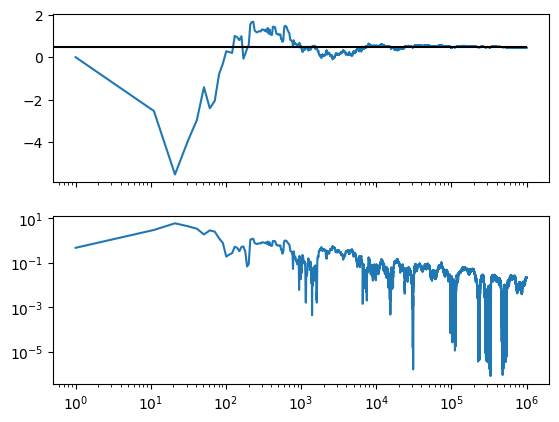

In [12]:
eps2_errors = np.abs(np.array(eps2_sampled) - eps2_exact)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(num_samples, eps2_sampled)
ax[0].hlines(eps2_exact, 0., max(num_samples), colors="k")
ax[0].set_xscale("log")
ax[1].plot(num_samples, eps2_errors)
ax[1].set_yscale("log")

## Hubbard

In [13]:
l1 = 3
l2 = 2
t = 1.0
u = 4.0
max_mpo_bond = 100
max_mps_bond = 15
evol_time = 0.1
energy_error = 1e-3

ham = of.fermi_hubbard(l1, l2, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs]
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
ham_mpo = pauli_sum_to_mpo(ham_cirq, qs, max_mpo_bond)

Hamiltonian has 34 terms.
Hamiltonian has 6 qubits.


In [14]:
# Get an approximate ground state using DMRG.
dmrg = qtn.tensor_dmrg.DMRG(ham_mpo, max_mps_bond)
converged = dmrg.solve()
if not converged:
    print("DMRG did not converge!")
ground_state = dmrg.state
ground_energy = dmrg.energy.real
print(f"Final DMRG energy: {ground_energy:4.5e}")
ground_state_vector = mps_to_vector(ground_state)

Final DMRG energy: -3.12311e+00
sorted_inds = ['k0', 'k1', 'k2', 'k3', 'k4', 'k5']


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)


In [15]:
# Use the exact method.
groups = group_single_strings(ham_cirq)
v2 = trotter_perturbation(groups)
v2_mpo = pauli_sum_to_mpo(v2, qs, max_mpo_bond)
v2_matrix = v2.matrix()
# Get energy from Mehendale Eqn. 8
eps2 = (ground_state.H @ v2_mpo.apply(ground_state)).real
print(f"eps2 = {eps2:4.5e}")
eps2_statevector = np.vdot(ground_state_vector, v2_matrix @ ground_state_vector).real
print(f"Statevector eps2 = {eps2_statevector:4.5e}")
dt = sqrt(energy_error / eps2)
num_steps = ceil(evol_time / dt)
print(f"dt = {dt:4.5e}, n_steps = {num_steps}")


mu = 0 nu = 1 nu_prime = 1
mu = 0 nu = 1 nu_prime = 2
mu = 0 nu = 1 nu_prime = 3
mu = 0 nu = 1 nu_prime = 4
mu = 0 nu = 1 nu_prime = 5
mu = 0 nu = 1 nu_prime = 6
mu = 0 nu = 1 nu_prime = 7
mu = 0 nu = 1 nu_prime = 8
mu = 0 nu = 1 nu_prime = 9
mu = 0 nu = 1 nu_prime = 10
mu = 0 nu = 1 nu_prime = 11
mu = 0 nu = 1 nu_prime = 12
mu = 0 nu = 1 nu_prime = 13
mu = 0 nu = 1 nu_prime = 14
mu = 0 nu = 1 nu_prime = 15
mu = 0 nu = 1 nu_prime = 16
mu = 0 nu = 1 nu_prime = 17
mu = 0 nu = 1 nu_prime = 18
mu = 0 nu = 1 nu_prime = 19
mu = 0 nu = 1 nu_prime = 20
mu = 0 nu = 1 nu_prime = 21
mu = 0 nu = 1 nu_prime = 22
mu = 0 nu = 1 nu_prime = 23
mu = 0 nu = 1 nu_prime = 24
mu = 0 nu = 1 nu_prime = 25
mu = 0 nu = 1 nu_prime = 26
mu = 0 nu = 1 nu_prime = 27
mu = 0 nu = 1 nu_prime = 28
mu = 0 nu = 1 nu_prime = 29
mu = 0 nu = 1 nu_prime = 30
mu = 0 nu = 1 nu_prime = 31
mu = 0 nu = 1 nu_prime = 32
mu = 0 nu = 1 nu_prime = 33
mu = 0 nu = 1 nu_prime = 34
mu = 0 nu = 1 nu_prime = 35
mu = 0 nu = 1 nu_prime = 36
m

/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: divide by zero encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: overflow encountered in matmul
  return func(*args, **kwargs)
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/autoray/autoray.py:81: RuntimeWarning: invalid value encountered in matmul
  return func(*args, **kwargs)
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_3456/4245560867.py:9: RuntimeWarning: divide by zero encountered in matmul
  eps2_statevector = np.vdot(ground_state_vector, v2_matrix @ ground_state_vector).real
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000gn/T/ipykernel_3456/4245560867.py:9: RuntimeWarning: overflow encountered in matmul
  eps2_statevector = np.vdot(ground_state_vector, v2_matrix @ ground_state_vector).real
/var/folders/62/vpq4vzfx3zlfyyr3mw8zdmrc0000

In [16]:
samples = 10_000_000
reps = 1
all_samples = []
for _ in range(reps):
    sample_nums, eps2_sampled, _ = sample_eps2(ham_cirq, qs, ground_state, samples)
    all_samples.append(eps2_sampled)
all_samples = np.array(all_samples)

In [17]:
eps2_average = np.average(all_samples, axis=0)
eps2_std = np.std(all_samples, axis=0)

print(eps2_average[-1])
print(eps2_std[-1])

1.6761505531156864
0.0


0.16195286031575803


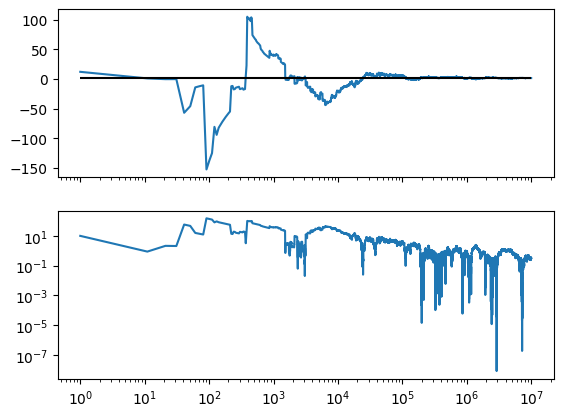

In [20]:
eps2_errors = np.abs(eps2_average - eps2)
print(eps2_errors[-1] / abs(eps2))

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(sample_nums, eps2_average)
ax[0].hlines(eps2, np.min(sample_nums), np.max(sample_nums), color="k")

ax[0].set_xscale("log")
ax[1].plot(sample_nums, eps2_errors)
ax[1].set_yscale("log")